In [97]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import VotingRegressor, BaggingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingRegressor
import time
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Load the dataset
data = pd.read_csv('data.csv')

In [30]:
data.head()

,Date,Product Name,Category,Units Sold,Price,Revenue,Discount,Units Returned,Location,Platform
0,2020-01-06,Whey Protein,Protein,143,31.98,4573.14,0.03,2,Canada,Walmart
1,2020-01-06,Vitamin C,Vitamin,139,42.51,5908.89,0.04,0,UK,Amazon
2,2020-01-06,Fish Oil,Omega,161,12.91,2078.51,0.25,0,Canada,Amazon
3,2020-01-06,Multivitamin,Vitamin,140,16.07,2249.80,0.08,0,Canada,Walmart
4,2020-01-06,Pre-Workout,Performance,157,35.47,5568.79,0.25,3,Canada,iHerb


In [58]:
data["Date"]= pd.to_datetime(data["Date"])
data["Date"]

0      2020-01-06
1      2020-01-06
2      2020-01-06
3      2020-01-06
4      2020-01-06
          ...    
4379   2025-03-31
4380   2025-03-31
4381   2025-03-31
4382   2025-03-31
4383   2025-03-31
Name: Date, Length: 4384, dtype: datetime64[ns]

In [60]:
print(data['Platform'] == "Amazon" )

0       False
1        True
2        True
3       False
4       False
        ...  
4379    False
4380    False
4381    False
4382     True
4383    False
Name: Platform, Length: 4384, dtype: bool


In [62]:
amazon = data[data['Platform'] == "Amazon"]

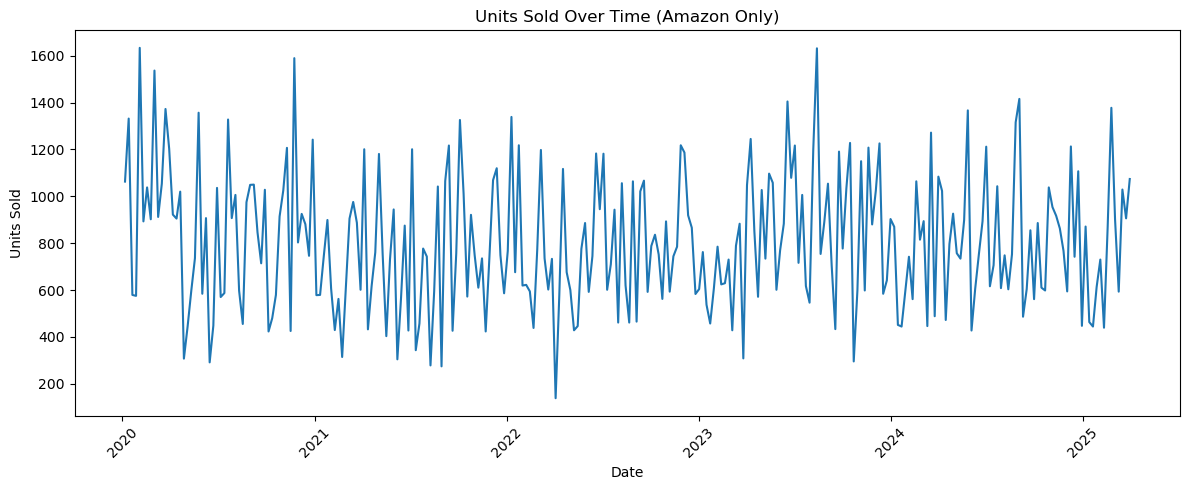

This plot represents Amazon platform sales only.
Units sold remain within a similar range (approximately 200 to 1600) from 2020 to 2025 in USA, UK, and Canada.


In [66]:
# Plot EDA for Amazon dataset
plt.figure(figsize=(12, 5))
df_sum = amazon.groupby("Date")["Units Sold"].sum().reset_index()
sns.lineplot(x="Date", y="Units Sold", data=df_sum)
plt.title("Units Sold Over Time (Amazon Only)")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("This plot represents Amazon platform sales only.\nUnits sold remain within a similar range (approximately 200 to 1600) from 2020 to 2025 in USA, UK, and Canada.")

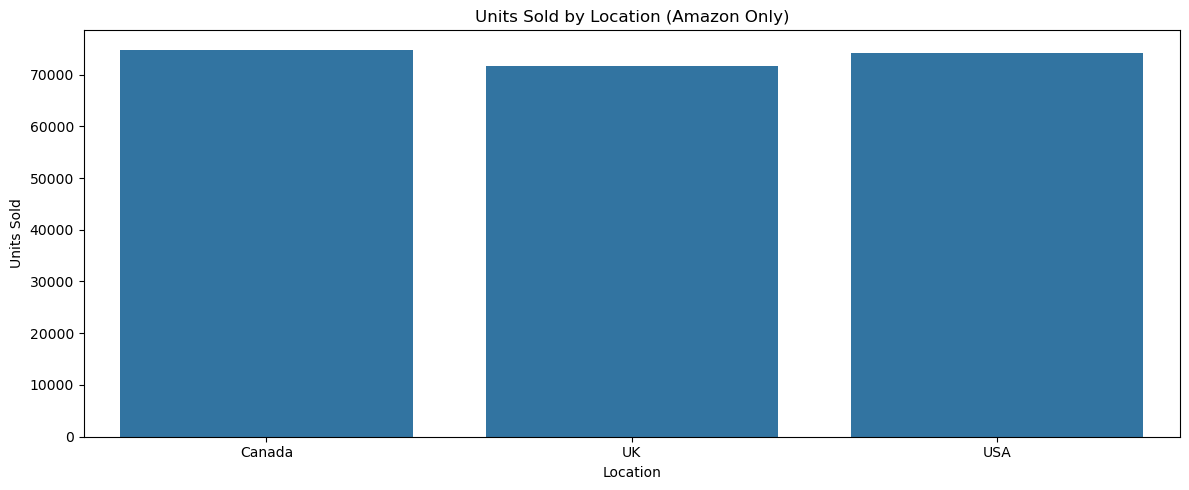

Total units sold across locations on Amazon fall around 70,000.


In [54]:
# Group Amazon data by Location
df_location = amazon.groupby("Location")["Units Sold"].sum().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Location", y="Units Sold", data=df_location)
plt.title("Units Sold by Location (Amazon Only)")
plt.xlabel("Location")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

print("Total units sold across locations on Amazon fall around 70,000.")


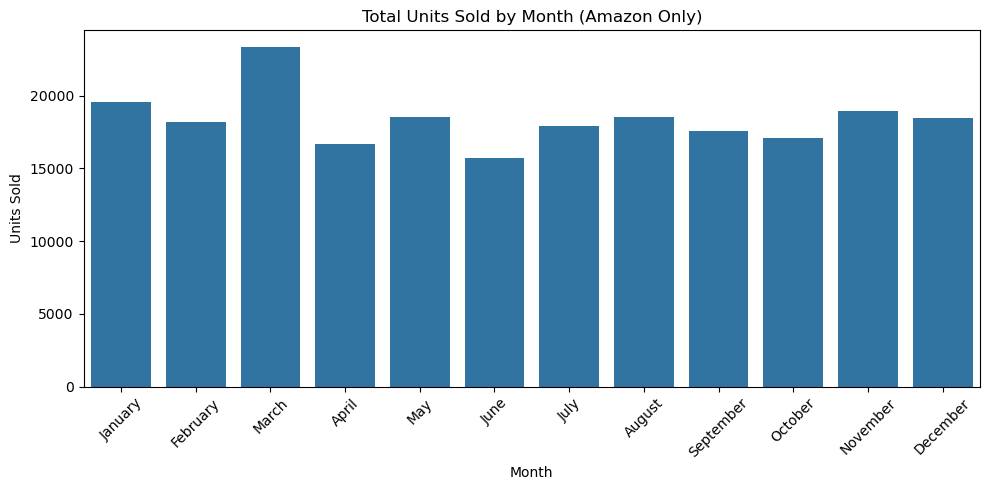

January and March have the highest units sold on Amazon, both exceeding 45,000.
Other months are under 20000.
This shows that Amazon has consistent customer demand throughout the year.


In [70]:
# Create a copy of the Amazon dataset
df_year = amazon.copy()

# Convert 'Date' to datetime if not already
df_year["Date"] = pd.to_datetime(df_year["Date"])

# Extract month names
df_year["Month"] = df_year["Date"].dt.month_name()

# Group by month
monthly_sales = df_year.groupby("Month")["Units Sold"].sum().reset_index()

# Define month order for consistent sorting
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales['Month'] = pd.Categorical(monthly_sales['Month'], categories=month_order, ordered=True)
monthly_sales = monthly_sales.sort_values("Month")

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Month", y="Units Sold", data=monthly_sales)
plt.title("Total Units Sold by Month (Amazon Only)")
plt.ylabel("Units Sold")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("January and March have the highest units sold on Amazon, both exceeding 45,000.")
print("Other months are under 20000.")
print("This shows that Amazon has consistent customer demand throughout the year.")


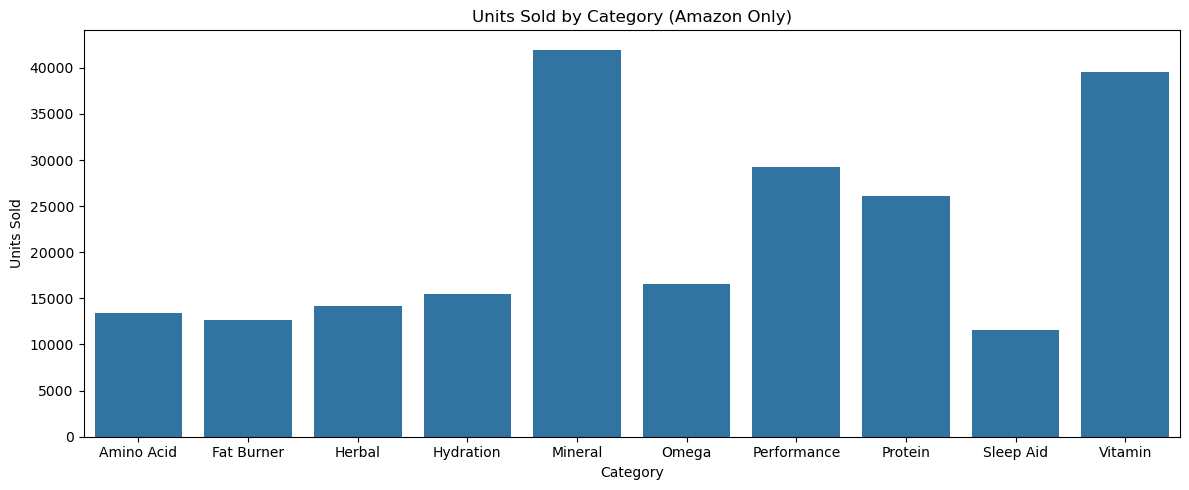

Top-Selling Categories on Amazon: Mineral and Vitamin categories are clearly the top performers, with units sold exceeding more 80,000 for both.
Good-Selling Categories: Performance and Protein also show strong sales, both at around 60,000 units.


In [74]:
# Group Amazon data by Category
df_sum = amazon.groupby("Category")["Units Sold"].sum().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Category", y="Units Sold", data=df_sum)
plt.title("Units Sold by Category (Amazon Only)")
plt.xlabel("Category")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

print("Top-Selling Categories on Amazon: Mineral and Vitamin categories are clearly the top performers, with units sold exceeding more 80,000 for both.")
print("Good-Selling Categories: Performance and Protein also show strong sales, both at around 60,000 units.")


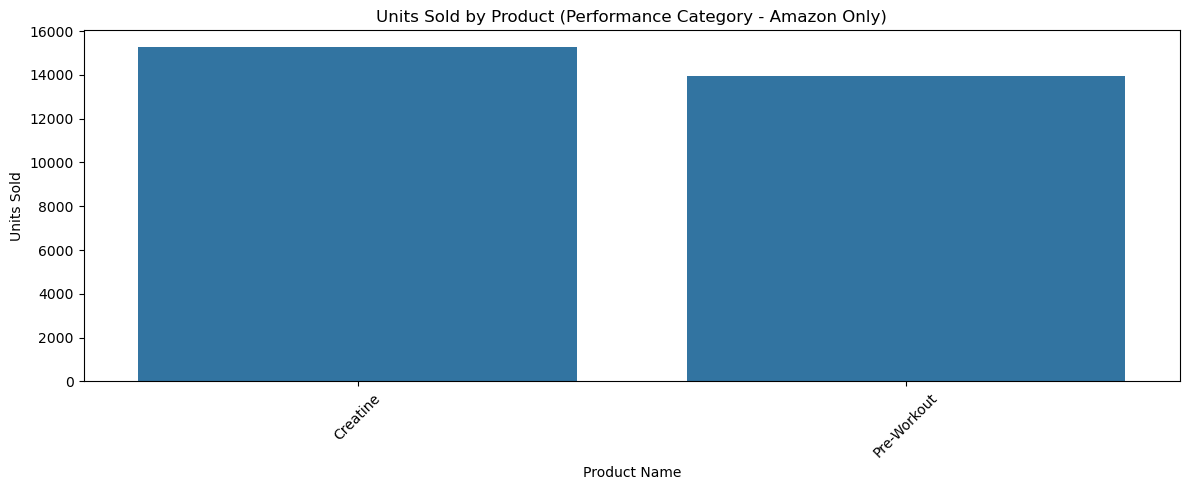

Each product in the Performance category on Amazon appears to have sold a similar number of units.


In [76]:
# Filter Amazon data for Category = "Performance"
df_cat = amazon[amazon["Category"] == "Performance"]

# Optional: check product counts (not plotted)
product_counts = df_cat["Product Name"].value_counts()

# Group by Product Name to get total units sold
df_sum = df_cat.groupby("Product Name")["Units Sold"].sum().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Product Name", y="Units Sold", data=df_sum)
plt.title("Units Sold by Product (Performance Category - Amazon Only)")
plt.xlabel("Product Name")
plt.ylabel("Units Sold")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Comment
print("Each product in the Performance category on Amazon appears to have sold a similar number of units.")


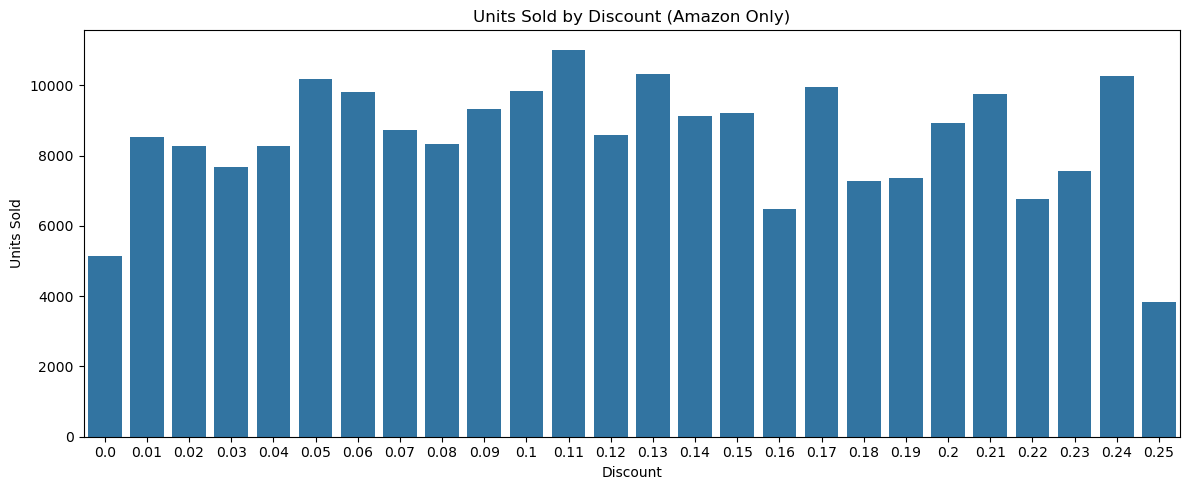

Moderate discounts (around 5% to 15%) are associated with the highest units sold on Amazon, while both no discount and high discounts (e.g., 25%) result in noticeably lower sales.


In [80]:
# Group Amazon data by Discount
df_percentage = amazon.groupby("Discount")["Units Sold"].sum().reset_index()

# Plot
plt.figure(figsize=(12, 5))
sns.barplot(x="Discount", y="Units Sold", data=df_percentage)
plt.title("Units Sold by Discount (Amazon Only)")
plt.xlabel("Discount")
plt.ylabel("Units Sold")
plt.tight_layout()
plt.show()

# Interpretation
print("Moderate discounts (around 5% to 15%) are associated with the highest units sold on Amazon, while both no discount and high discounts (e.g., 25%) result in noticeably lower sales.")


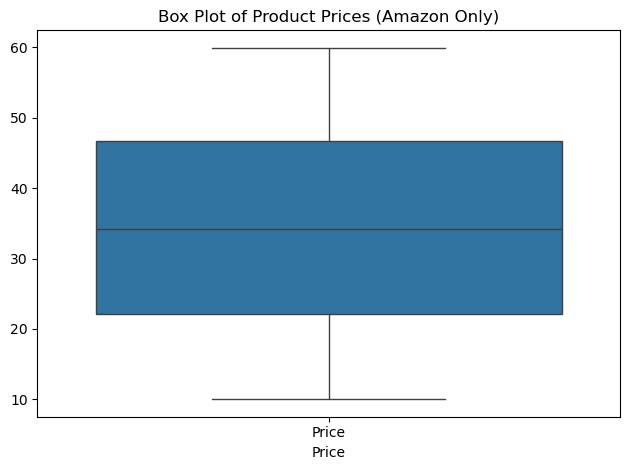

In [82]:
# Boxplot of Price for Amazon data
sns.boxplot(data=amazon[['Price']])
plt.title("Box Plot of Product Prices (Amazon Only)")
plt.xlabel("Price")
plt.tight_layout()
plt.show()


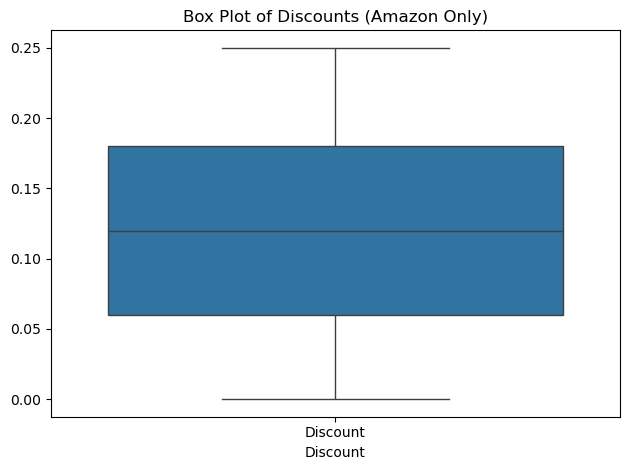

In [84]:
# Boxplot of Discount for Amazon data
sns.boxplot(data=amazon[['Discount']])
plt.title("Box Plot of Discounts (Amazon Only)")
plt.xlabel("Discount")
plt.tight_layout()
plt.show()


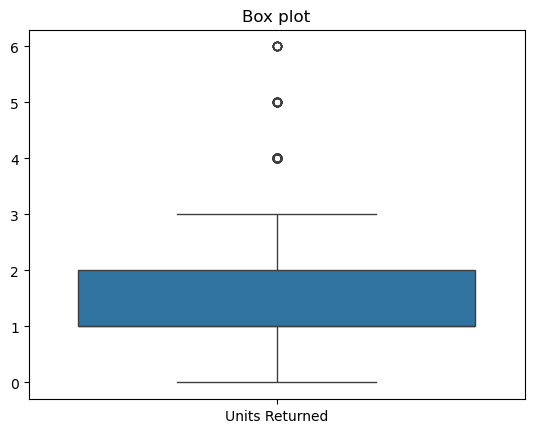

4,5,6 are outliers in Units Returned column


In [88]:
sns.boxplot(data = amazon[['Units Returned']])
plt.title("Box plot")
plt.show()

print("4,5,6 are outliers in Units Returned column")

# TRaining Stacking Model ( Platform Amazon)

In [112]:
# Make a copy of the DataFrame (especially if it's a slice)
amazon_df = amazon.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
amazon_df['Date'] = pd.to_datetime(amazon_df['Date'])
amazon_df['Year'] = amazon_df['Date'].dt.year
amazon_df['Month'] = amazon_df['Date'].dt.month

# Now it's safe to drop 'Date'
amazon_df = amazon_df.drop(columns=['Product Name', 'Date', 'Units Sold','Location'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = amazon_df[features]
y = amazon_df[target]

In [114]:
amazon_df.head()

,Category,Price,Revenue,Discount,Units Returned,Platform,Year,Month
1,Vitamin,42.51,5908.89,0.04,0,Amazon,2020,1
2,Omega,12.91,2078.51,0.25,0,Amazon,2020,1
7,Mineral,46.68,6861.96,0.19,0,Amazon,2020,1
8,Protein,10.96,1611.12,0.06,2,Amazon,2020,1
9,Mineral,20.76,2781.84,0.00,0,Amazon,2020,1


In [116]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [118]:
# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]

# Define meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Measure training time
start_time = time.time()
stacking_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict and measure prediction time
start_time = time.time()
y_pred_stack = stacking_model.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test, y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')
print(f'Training Time: {training_time:.4f} seconds')
print(f'Prediction Time: {prediction_time:.4f} seconds')

# Estimate model complexity
print("\nModel Complexity:")
for name, model in stacking_model.named_estimators_.items():
    if isinstance(model, LinearRegression):
        print(f"{name} (Linear Regression): {model.coef_.shape[0]} coefficients")
    elif isinstance(model, DecisionTreeRegressor):
        print(f"{name} (Decision Tree): Depth = {model.get_depth()}, Nodes = {model.tree_.node_count}")

# Meta-model complexity
if hasattr(stacking_model.final_estimator_, 'coef_'):
    print(f"Meta-model (Linear Regression): {stacking_model.final_estimator_.coef_.shape[0]} coefficients")

Mean Squared Error: 212810.1938, R²: 0.9562
Training Time: 0.0775 seconds
Prediction Time: 0.0040 seconds

Model Complexity:
lr (Linear Regression): 14 coefficients
dt (Decision Tree): Depth = 27, Nodes = 2355
Meta-model (Linear Regression): 2 coefficients


# Training Stacking Model ( Platform Walmart)

In [133]:
walmart = data[data['Platform'] == "Walmart"]

In [135]:
# Make a copy of the DataFrame (especially if it's a slice)
walmart_df = walmart.copy()

# Convert Date to datetime and extract year and month BEFORE dropping the column
walmart_df['Date'] = pd.to_datetime(walmart_df['Date'])
walmart_df['Year'] = walmart_df['Date'].dt.year
walmart_df['Month'] = walmart_df['Date'].dt.month

# Now it's safe to drop 'Date'
walmart_df = walmart_df.drop(columns=['Product Name', 'Date', 'Units Sold','Location'])

# Define features and target
numerical_cols = ['Price', 'Discount', 'Units Returned', 'Year', 'Month']
categorical_cols = ['Category']
features = numerical_cols + categorical_cols
target = 'Revenue'

# Split features and target
X = walmart_df[features]
y = walmart_df[target]

In [137]:
walmart_df.head()

,Category,Price,Revenue,Discount,Units Returned,Platform,Year,Month
0,Protein,31.98,4573.14,0.03,2,Walmart,2020,1
3,Vitamin,16.07,2249.80,0.08,0,Walmart,2020,1
5,Amino Acid,41.19,6343.26,0.13,1,Walmart,2020,1
6,Performance,32.49,4353.66,0.05,1,Walmart,2020,1
11,Sleep Aid,34.41,5643.24,0.04,1,Walmart,2020,1


In [139]:
# Preprocessing: One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_cols)
    ])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Get feature names after one-hot encoding
cat_encoder = preprocessor.named_transformers_['cat']
cat_feature_names = cat_encoder.get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(cat_feature_names)

# Convert processed data to DataFrame for easier handling
X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)

In [141]:
# Define base models
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor(random_state=42))
]

# Define meta-model
meta_model = LinearRegression()

# Create Stacking Regressor
stacking_model = StackingRegressor(estimators=base_models, final_estimator=meta_model, cv=5)

# Measure training time
start_time = time.time()
stacking_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Predict and measure prediction time
start_time = time.time()
y_pred_stack = stacking_model.predict(X_test)
prediction_time = time.time() - start_time

# Evaluate the model
mse = mean_squared_error(y_test, y_pred_stack)
r2_stacking = r2_score(y_test, y_pred_stack)
print(f'Mean Squared Error: {mse:.4f}, R²: {r2_stacking:.4f}')
print(f'Training Time: {training_time:.4f} seconds')
print(f'Prediction Time: {prediction_time:.4f} seconds')

# Estimate model complexity
print("\nModel Complexity:")
for name, model in stacking_model.named_estimators_.items():
    if isinstance(model, LinearRegression):
        print(f"{name} (Linear Regression): {model.coef_.shape[0]} coefficients")
    elif isinstance(model, DecisionTreeRegressor):
        print(f"{name} (Decision Tree): Depth = {model.get_depth()}, Nodes = {model.tree_.node_count}")

# Meta-model complexity
if hasattr(stacking_model.final_estimator_, 'coef_'):
    print(f"Meta-model (Linear Regression): {stacking_model.final_estimator_.coef_.shape[0]} coefficients")

Mean Squared Error: 233739.1420, R²: 0.9480
Training Time: 0.0656 seconds
Prediction Time: 0.0030 seconds

Model Complexity:
lr (Linear Regression): 14 coefficients
dt (Decision Tree): Depth = 23, Nodes = 2257
Meta-model (Linear Regression): 2 coefficients


# Traning Stacking Model ( Platform iHerb)


In [ ]:
walmart = data[data['Platform'] == "Walmart"]